<a href="https://colab.research.google.com/github/Taehee-K/Fractured-Bone-Classification/blob/code/VGG9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/2021/2021-1/패턴인식과머신러닝/Project')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


# Split Data

In [ ]:
import shutil
 
original_dataset_dir = './Train'                  # 기존의 train 데이터
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = './Split'                              # train-validation 데이터 나누어 저장
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'Train')       # train data
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'Val')    # validation data
os.mkdir(validation_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))

In [ ]:
## 데이터 분할 후 클래스별 데이터 수 확인
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.8)
    validation_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Fractured ):  140
Validation size( Fractured ):  36
Train size( Normal ):  141
Validation size( Normal ):  36


In [ ]:
original_dataset_dir = './Train'                  # 기존의 train 데이터
classes_list = os.listdir(original_dataset_dir) 

print(len(classes_list))
print(classes_list)           # 분류해야 할 클래스들

2
['Fractured', 'Normal']


# Load Data

Training image 가 총 281개로 적은 수이기 때문에 RandomHorizontalFlip()을 활용해 각각 50%의 확률로 데이터를 좌우반전시켜 data augmentation을 진행하였다.

In [ ]:
BATCH_SIZE = 32
EPOCH = 100

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(400),         # crop to 400
        transforms.RandomHorizontalFlip(),  # Horizontal Flip Randomly(p=50)
        transforms.Grayscale(num_output_channels = 1)]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),              
        transforms.CenterCrop(400),         # crop to 400
        transforms.Grayscale(num_output_channels = 1)])
}
 
train_dataset = ImageFolder(root='./Split/Train', transform = data_transforms['train'])
val_dataset = ImageFolder(root='./Split/Val', transform = data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         num_workers=4)

torch.Size([32, 1, 400, 400])
Label = 1 : Fracture image


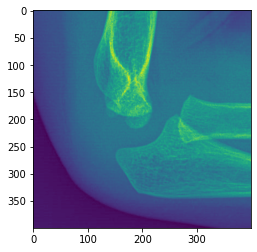

torch.Size([32, 1, 400, 400])
Label = 1 : Fracture image


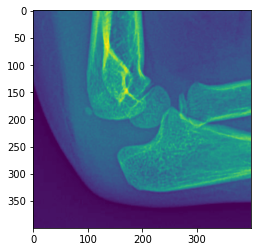

torch.Size([8, 1, 400, 400])
Label = 0 : Normal image


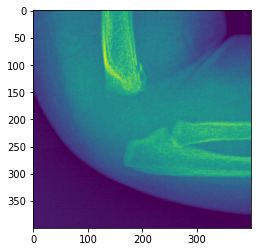

In [ ]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in val_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.numpy()
        l = l.numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

# VGG9 Model

* Build Model

In [ ]:
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(51200,2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x

model = Net().to(DEVICE)  # 모델 GPU로
model # Print network

Net(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
 

In [ ]:
summary(model, (1, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 398, 398]             160
              ReLU-2         [-1, 16, 398, 398]               0
            Conv2d-3         [-1, 16, 396, 396]           2,320
              ReLU-4         [-1, 16, 396, 396]               0
         MaxPool2d-5         [-1, 16, 197, 197]               0
            Conv2d-6         [-1, 32, 195, 195]           4,640
              ReLU-7         [-1, 32, 195, 195]               0
            Conv2d-8         [-1, 32, 193, 193]           9,248
              ReLU-9         [-1, 32, 193, 193]               0
        MaxPool2d-10           [-1, 32, 96, 96]               0
           Conv2d-11           [-1, 64, 94, 94]          18,496
             ReLU-12           [-1, 64, 94, 94]               0
           Conv2d-13           [-1, 64, 92, 92]          36,928
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

* Train Model

In [ ]:
def train(model, train_loader, optimizer):
    model.train()                         # 모델 train 상태로
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)  # data, target 값 DEVICE에 할당
        optimizer.zero_grad()                              # optimizer gradient 값 초기화
        output = model(data)                               # 할당된 데이터로 output 계산
        loss =  criterion(output, target)                  # Cross Entropy Loss 사용해 loss 계산
        loss.backward()                                    # 계산된 loss back propagation
        optimizer.step()                                   # parameter update

* Evaluate Model 

In [ ]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0       # 맞게 예측한 0 값으로 초기화
    
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     # data, target DEVICE에 할당
            output = model(data)                                  # output 계산
            test_loss += criterion(output, target).item()         # loss 계산(총 loss 에 더해주기)
            pred = output.max(1, keepdim=True)[1]                 # 계산된 벡터값 중 가장 큰 값 가지는 class 예측
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy

## Train Model

In [ ]:
import time
import copy
 
def train_model(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    acc_t = []; acc_v = []    # train, validation accuracy 저장할 list
    loss_t = []; loss_v = []  # train, validation loss 저장할 list

    best_acc = 0.0  # beset accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()                                     # 학습 시간 계산
        train(model, train_loader, optimizer)                   # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader)   # train_loss, train_acc 계산
        val_loss, val_acc = evaluate(model, val_loader)         # valid_loss, valid_acc 계산
        
        if val_acc>best_acc:  # update best accuracy
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())  # 가장 accuracy 높은 model 저장
        
        # loss, accuarcy 저장하기
        acc_t.append(train_acc); acc_v.append(val_acc)
        loss_t.append(train_loss);loss_v.append(val_loss)

        #학습 결과 및 시간 출력
        time_elapsed = time.time() - since 
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print() 

    # Accuracy Graph
    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Loss Graph
    plt.plot(range(len(loss_t)), loss_t, 'b', range(len(loss_v)), loss_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Loss')
    red_patch = mpatches.Patch(color='red', label='Validation Loss')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    model.load_state_dict(best_model_wts) # validation accuracy, 가장 높은 모델 저장
    return model

-------------- EPOCH 1 ----------------
Train Loss: 0.0222, Accuracy: 49.82%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 1m 9s

-------------- EPOCH 2 ----------------
Train Loss: 0.0222, Accuracy: 50.18%
Val Loss: 0.0287, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 3 ----------------
Train Loss: 0.0222, Accuracy: 50.18%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 4 ----------------
Train Loss: 0.0222, Accuracy: 50.18%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 5 ----------------
Train Loss: 0.0222, Accuracy: 50.18%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 6 ----------------
Train Loss: 0.0222, Accuracy: 50.18%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 7 ----------------
Train Loss: 0.0222, Accuracy: 58.01%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0m 13s

-------------- EPOCH 8 ----------------
Train Loss: 0.0222, Accuracy: 49.82%
Val Loss: 0.0289, Accuracy: 50.00%
Time: 0

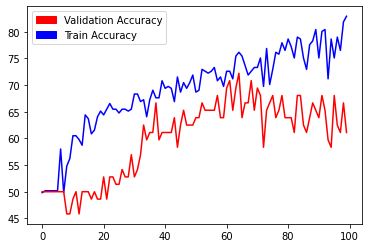

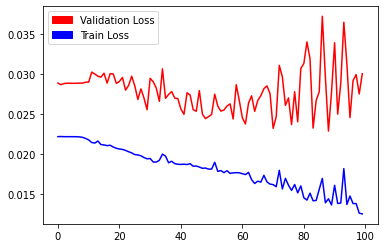

In [ ]:
model = train_model(model ,train_loader, val_loader, optimizer, EPOCH)  	# 모델 학습시키기

Accuracy graph와 Loss graph를 보면 학습이 진행되다가 epoch 80즘부터 overfitting이 진행되며 generalization error가 생긴 것을 확인할 수 있다.

* Validation Accuracy 가 가장 높은 모델 저장

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'VGG_Model_Taehee_1870027')

## Evaluate Model

In [ ]:
model=torch.load('VGG_Model_Taehee_1870027')
model.eval()
_, train_acc = evaluate(model, train_loader)
_, val_acc = evaluate(model, val_loader)

# prit saved model's train and validation accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Validation Accuracy: {:.4f}'.format(val_acc))

Train Accuracy: 72.9537
Validation Accuracy: 72.2222


* Print Classification Report

In [ ]:
from sklearn.metrics import classification_report
def prediction(model, data_loader):
    model.eval()
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
      for i, (data, label) in enumerate(data_loader):
        data = data.to(DEVICE)        # 데이터 DEVICE에 할당
        label = label.to(DEVICE)      # 라벨 값 DEVICE에 할당
        outputs = model(data)         # 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        
    # Classification Report
    print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
    return

In [ ]:
prediction(model, val_loader)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        36
           1       0.75      0.67      0.71        36

    accuracy                           0.72        72
   macro avg       0.72      0.72      0.72        72
weighted avg       0.73      0.72      0.72        72



Fractured 와 Normal class 의 F1-Score가 각각 0.74와 0.71로 Normal을 Fractured로 잘못 판단한 경우가 더 많은 것을 확인할 수 있다. <br>
Train Accuracy: 74.7331, Validation Accuracy: 72.2222 을 통해 모델의 capacity 자체가 높지 않다고 판단할 수 있다.